# Проект: телекоммуникации

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Задача — обучить на этих данных модель для прогноза оттока клиентов.  
  
  
  

**Описание данных**  
Данные состоят из нескольких файлов, полученных из разных источников:
* `contract_new.csv` — информация о договоре;
* `personal_new.csv` — персональные данные клиента;
* `internet_new.csv` — информация об интернет-услугах;
* `phone_new.csv` — информация об услугах телефонии.


**План работы** 
* Загрузить данные
* Исследовать и предобработать данные
* Объединить данные
* Исследовать и предобработать объединённые данные
* Подготовить данные к обучению на них моделей МО
* Обучение нескольких моделей
* Выбор лучшей модели для решения поставленной задачи
* Общий вывод по проделанной работе, рекомендации заказчику

**Объявление библиотек и глобальных переменных и настроек:**

In [1]:
pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install phik

In [3]:
from sklearn.linear_model import LogisticRegression  # Модели МО
from catboost import CatBoostClassifier, Pool        #
from sklearn.ensemble import RandomForestClassifier  #


from sklearn.model_selection import RandomizedSearchCV, GridSearchCV             # Вспомогательные функции
from sklearn.compose import make_column_transformer                              #
from sklearn.metrics import roc_auc_score, accuracy_score                        #
from sklearn.model_selection import train_test_split                             #
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler  #
from phik import phik_matrix                                                     #


import pandas as pd                       # Математика
import numpy as np                        #
import math as m                          #
from scipy.stats import uniform, randint  #


import matplotlib.pyplot as plt      # Визуализация
import seaborn as sns                #
from IPython.display import display  #


import warnings                    # Отключение предупреждений
warnings.filterwarnings("ignore")  #

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [4]:
RANDOM_SEED = 190224

In [5]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [6]:
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 20
sns.set_style("whitegrid")

## Загрузка данных

In [7]:
contract_df = pd.read_csv('/datasets/contract_new.csv')
personal_df = pd.read_csv('/datasets/personal_new.csv')
internet_df = pd.read_csv('/datasets/internet_new.csv')
phone_df = pd.read_csv('/datasets/phone_new.csv')

In [8]:
df_dict = { 'Contract df': contract_df,
            'Personal df': personal_df,
            'Internet df': internet_df,
            'Phone df': phone_df}

In [9]:
for i in df_dict:
    print(color.BOLD + i + ':' + color.END)
    display(df_dict[i].sample(10, random_state=RANDOM_SEED))
    print('-----------------------------------------------------------------------------------------------------------')

Contract df:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
3115,4822-NGOCH,2018-12-01,No,Month-to-month,Yes,Electronic check,84.45,1241.41
2086,2955-BJZHG,2018-08-01,2019-10-01,Month-to-month,No,Electronic check,80.85,1131.9
610,6543-CPZMK,2019-02-01,No,Month-to-month,Yes,Electronic check,29.95,359.4
912,3865-YIOTT,2014-02-01,2017-05-01,One year,Yes,Bank transfer (automatic),106.10,4179.28
6572,6258-PVZWJ,2014-06-01,No,Two year,Yes,Credit card (automatic),90.80,6174.4
3880,9470-RTWDV,2017-12-01,No,One year,Yes,Credit card (automatic),82.00,2132.0
2669,4659-NZRUF,2018-04-01,No,Month-to-month,Yes,Electronic check,95.15,2093.3
2141,6648-INWPS,2018-10-01,No,Month-to-month,No,Electronic check,20.15,338.52
5396,5627-TVBPP,2017-03-01,No,One year,Yes,Credit card (automatic),20.10,703.5
3306,9643-AVVWI,2019-11-01,No,Month-to-month,Yes,Electronic check,80.00,249.6


-----------------------------------------------------------------------------------------------------------
Personal df:


,customerID,gender,SeniorCitizen,Partner,Dependents
3115,4822-NGOCH,Female,0,No,No
2086,2955-BJZHG,Male,0,Yes,Yes
610,6543-CPZMK,Male,0,Yes,Yes
912,3865-YIOTT,Male,0,Yes,Yes
6572,6258-PVZWJ,Male,0,Yes,No
3880,9470-RTWDV,Male,0,Yes,Yes
2669,4659-NZRUF,Female,0,No,No
2141,6648-INWPS,Male,0,Yes,Yes
5396,5627-TVBPP,Female,0,No,Yes
3306,9643-AVVWI,Female,0,Yes,Yes


-----------------------------------------------------------------------------------------------------------
Internet df:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
2082,5609-IMCGG,Fiber optic,Yes,No,Yes,No,No,No
3221,5208-FVQKB,DSL,Yes,Yes,No,Yes,No,Yes
5243,4342-HFXWS,DSL,Yes,No,Yes,Yes,Yes,No
3457,8652-YHIYU,Fiber optic,No,No,No,Yes,No,No
3655,6305-YLBMM,Fiber optic,No,Yes,Yes,Yes,Yes,Yes
453,3716-UVSPD,DSL,No,No,No,Yes,No,No
1395,3669-WHAFY,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes
4438,2896-TBNBE,Fiber optic,No,Yes,Yes,No,No,No
2976,5914-DVBWJ,Fiber optic,No,Yes,No,Yes,No,No
2016,3230-WYKIR,DSL,No,No,Yes,Yes,Yes,Yes


-----------------------------------------------------------------------------------------------------------
Phone df:


,customerID,MultipleLines
682,3115-CZMZD,No
4249,0980-FEXWF,No
3388,1965-DDBWU,Yes
5760,8073-IJDCM,No
1317,2958-NHPPS,No
786,3313-QKNKB,Yes
4441,2673-ZALNP,No
3115,8749-JMNKX,Yes
4035,6161-UUUTA,No
4301,8748-HFWBO,No


-----------------------------------------------------------------------------------------------------------


По данным, пока, мало что ясно. Видно, что у всех таблиц разное число строк и есть общий столбец: `customerID`. По нему и будет проводиться объединение всех таблиц.

Для удобства переименуем столбцы:

In [10]:
contract_df.columns = ['customer_id', 'begin_date', 'end_date', 'type',
                       'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges']

personal_df.columns = ['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents']

internet_df.columns = ['customer_id', 'internet_service', 'online_security',
                       'online_backup', 'device_protection', 'tech_support',
                       'streaming_tv', 'streaming_movies']

phone_df.columns = ['customer_id', 'multiple_lines']

In [11]:
for i in df_dict:
    print(color.BOLD + i + ':' + color.END)
    print(df_dict[i].columns)

Contract df:
Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')
Personal df:
Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')
Internet df:
Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')
Phone df:
Index(['customer_id', 'multiple_lines'], dtype='object')


**=>** столбцы переименованы

## Исследовательский анализ и предобработка данных

Объявим функцию, печатающую основную информацию о любом датасете:

In [12]:
def df_info(df):
    
    df.info()                                       # общая информация
    display(df.describe(include='all'))             #
    display(df.sample(5, random_state=RANDOM_SEED)) #
    
    print('\n')
    for col in df.columns:                                       # процент пропусков
        pct_missing = np.mean(df[col].isnull())                  #
        print('{} - {}%'.format(col, round(pct_missing*100, 3))) #
        
    for col in df.columns:                                               # если данные числовые - рисуем boxplot
        if (df[col].dtypes == 'float64') or (df[col].dtypes == 'int64'): #
            sns.boxplot(x=contract_df['monthly_charges'])                #
    
    dup = df.duplicated().sum()   # Поиск дубликатов
    print('\nДубликатов:', dup)   #
    if dup > 0:                   #
        df = df.drop_duplicates() #

**contract_df**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,67,3,2,4,NaN,6658
top,3190-ITQXP,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5942,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
3115,4822-NGOCH,2018-12-01,No,Month-to-month,Yes,Electronic check,84.45,1241.41
2086,2955-BJZHG,2018-08-01,2019-10-01,Month-to-month,No,Electronic check,80.85,1131.9
610,6543-CPZMK,2019-02-01,No,Month-to-month,Yes,Electronic check,29.95,359.4
912,3865-YIOTT,2014-02-01,2017-05-01,One year,Yes,Bank transfer (automatic),106.10,4179.28
6572,6258-PVZWJ,2014-06-01,No,Two year,Yes,Credit card (automatic),90.80,6174.4




customer_id - 0.0%
begin_date - 0.0%
end_date - 0.0%
type - 0.0%
paperless_billing - 0.0%
payment_method - 0.0%
monthly_charges - 0.0%
total_charges - 0.0%

Дубликатов: 0


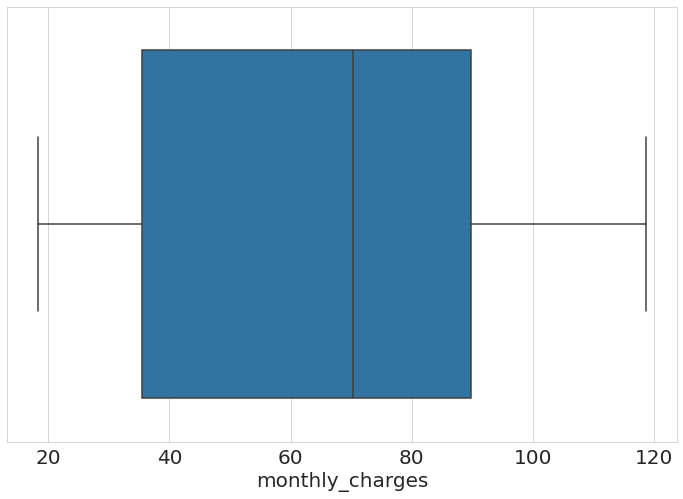

In [13]:
df_info(contract_df)

Видно, что выбросов нет

Приведём столбцы с датами к нужному типу:

In [14]:
contract_df['begin_date'].unique()

array(['2020-01-01', '2017-04-01', '2019-10-01', '2016-05-01',
       '2019-09-01', '2019-03-01', '2018-04-01', '2019-04-01',
       '2017-07-01', '2014-12-01', '2019-01-01', '2018-10-01',
       '2015-04-01', '2015-09-01', '2018-01-01', '2014-05-01',
       '2015-10-01', '2014-03-01', '2018-05-01', '2019-11-01',
       '2019-02-01', '2016-01-01', '2017-08-01', '2015-12-01',
       '2014-02-01', '2018-06-01', '2019-12-01', '2017-11-01',
       '2019-06-01', '2016-04-01', '2017-02-01', '2018-12-01',
       '2014-04-01', '2018-09-01', '2014-11-01', '2016-07-01',
       '2015-02-01', '2018-07-01', '2014-08-01', '2016-03-01',
       '2018-08-01', '2014-10-01', '2015-06-01', '2016-08-01',
       '2019-05-01', '2017-03-01', '2016-02-01', '2017-09-01',
       '2014-09-01', '2017-12-01', '2016-12-01', '2017-06-01',
       '2015-05-01', '2016-10-01', '2016-09-01', '2019-08-01',
       '2019-07-01', '2017-05-01', '2017-10-01', '2014-07-01',
       '2018-03-01', '2015-01-01', '2018-11-01', '2015-

In [15]:
contract_df['begin_date'] = contract_df['begin_date'].astype('datetime64[ns]')

In [16]:
contract_df['end_date'].unique()

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

Значение `'No'` означает, что клиент ещё с нами. Для удобства, заменим это значение на дату сборки датасета (01-02-2020), а затем преобразуем столбец к типу дата:

In [18]:
contract_df['end_date'] = contract_df['end_date'].replace('No', '01-02-2020')
contract_df['end_date'].unique()

array(['01-02-2020', '2017-05-01', '2016-03-01', '2018-09-01',
       '2018-11-01', '2018-12-01', '2019-08-01', '2018-07-01',
       '2017-09-01', '2015-09-01', '2016-07-01', '2016-06-01',
       '2018-03-01', '2019-02-01', '2018-06-01', '2019-06-01',
       '2020-01-01', '2019-11-01', '2016-09-01', '2015-06-01',
       '2016-12-01', '2019-05-01', '2019-04-01', '2017-06-01',
       '2017-08-01', '2018-04-01', '2018-08-01', '2018-02-01',
       '2019-07-01', '2015-12-01', '2014-06-01', '2018-10-01',
       '2019-01-01', '2017-07-01', '2017-12-01', '2018-05-01',
       '2015-11-01', '2019-10-01', '2019-03-01', '2016-02-01',
       '2016-10-01', '2018-01-01', '2017-11-01', '2015-10-01',
       '2019-12-01', '2015-07-01', '2017-04-01', '2015-02-01',
       '2017-03-01', '2016-05-01', '2016-11-01', '2015-08-01',
       '2019-09-01', '2017-10-01', '2017-02-01', '2016-08-01',
       '2016-04-01', '2015-05-01', '2014-09-01', '2014-10-01',
       '2017-01-01', '2015-03-01', '2015-01-01', '2016-

In [19]:
contract_df['end_date'] = contract_df['end_date'].astype('datetime64[ns]')

Приведём также столбец `total_charges` к числовому типу:

In [20]:
count = 0
un_charges = contract_df['total_charges'].unique()

for i in un_charges:
    try:
        float(i)
    except:
        print(f'"{i}"')
        count += 1

" "


Мешающие данные выглядят как просто пропуск. Вероятно, эти клиенты ещё не успели ничего оплатить; посмотрим, сколько их в процентном соотношении:

In [21]:
print(str(round(count / len(un_charges) * 100, 2)) + '%')

0.02%


Плохих данных всего 0.02%, это крайне мало **=>** удалим их

In [22]:
contract_df = contract_df[~contract_df['total_charges'].isin([' '])]

Оставшиеся данные приводим к вещественному типу

In [23]:
contract_df['total_charges'] = contract_df['total_charges'].astype(float)

In [24]:
count = 0
un_charges = contract_df['total_charges'].unique()

for i in un_charges:
    try:
        float(i)
    except:
        print(f'"{i}"')
        count += 1

In [25]:
print(str(round(count / len(un_charges) * 100, 2)) + '%')

0.0%


**=>** Преобразование выполнено успешно. Посмотрим теперь распределение данных:

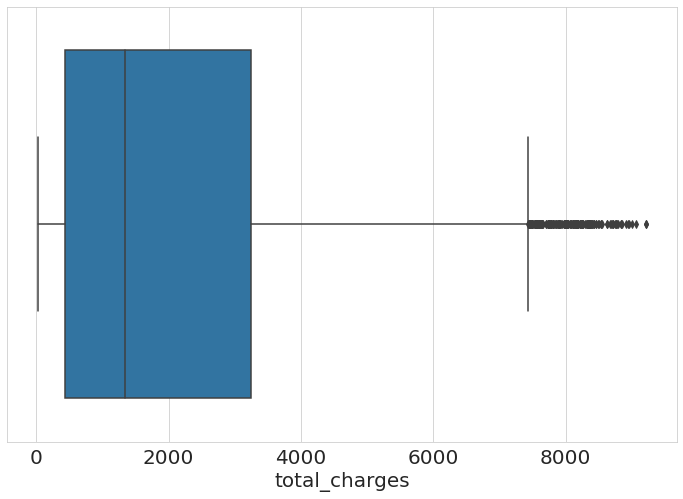

In [26]:
_ = sns.boxplot(x=contract_df['total_charges'])

Выбросов почти нет, оставим всё как есть

Добавим сразу же в эту таблицу столбец, в котором будет информация о том, сколько дней с нами был клиент на момент сбора данных:

In [27]:
contract_df['days_diff'] = (contract_df['end_date'] - contract_df['begin_date']).dt.days

In [28]:
contract_df.sample(10, random_state=RANDOM_SEED)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,days_diff
6719,2509-TFPJU,2014-02-01,2020-01-02,Two year,No,Credit card (automatic),25.75,1854.00,2161
6349,3451-VAWLI,2017-03-01,2020-01-02,Two year,No,Credit card (automatic),19.70,689.50,1037
6482,5419-JPRRN,2019-11-01,2020-01-02,Month-to-month,Yes,Electronic check,101.45,313.48,62
2240,3398-GCPMU,2014-02-01,2020-01-02,Two year,Yes,Credit card (automatic),89.55,7092.36,2161
2876,6746-WAUWT,2018-07-01,2020-01-02,One year,Yes,Credit card (automatic),19.70,374.30,550
3598,6185-TASNN,2020-01-01,2020-01-02,Month-to-month,No,Electronic check,46.30,46.30,1
2328,4238-JSSWH,2017-03-01,2020-01-02,Month-to-month,No,Bank transfer (automatic),102.05,3786.06,1037
6681,1389-CXMLU,2019-08-01,2020-01-02,Month-to-month,No,Electronic check,91.05,600.93,154
4461,0082-OQIQY,2017-09-01,2020-01-02,Month-to-month,Yes,Electronic check,94.20,2813.75,853
3051,5117-ZSMHQ,2014-03-01,2017-03-01,Two year,No,Bank transfer (automatic),89.90,3462.95,1096


**personal_df**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customer_id,gender,senior_citizen,partner,dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,3190-ITQXP,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


,customer_id,gender,senior_citizen,partner,dependents
3115,4822-NGOCH,Female,0,No,No
2086,2955-BJZHG,Male,0,Yes,Yes
610,6543-CPZMK,Male,0,Yes,Yes
912,3865-YIOTT,Male,0,Yes,Yes
6572,6258-PVZWJ,Male,0,Yes,No




customer_id - 0.0%
gender - 0.0%
senior_citizen - 0.0%
partner - 0.0%
dependents - 0.0%

Дубликатов: 0


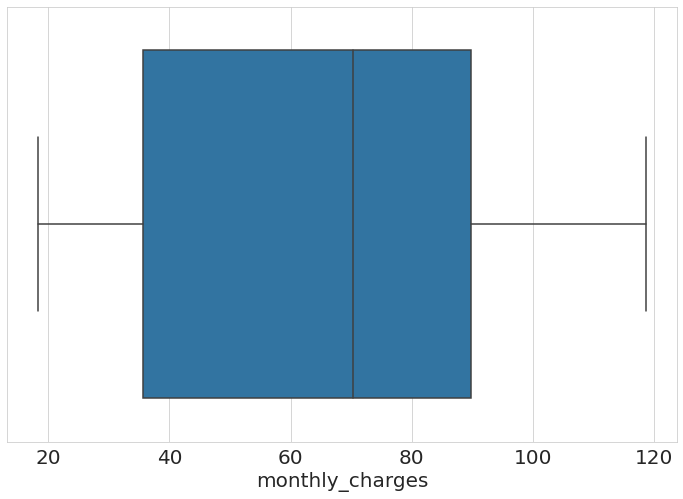

In [29]:
df_info(personal_df)

Здесь выбросов также не наблюдается

**internet_df**

In [30]:
df_info(internet_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,0080-EMYVY,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
2082,5609-IMCGG,Fiber optic,Yes,No,Yes,No,No,No
3221,5208-FVQKB,DSL,Yes,Yes,No,Yes,No,Yes
5243,4342-HFXWS,DSL,Yes,No,Yes,Yes,Yes,No
3457,8652-YHIYU,Fiber optic,No,No,No,Yes,No,No
3655,6305-YLBMM,Fiber optic,No,Yes,Yes,Yes,Yes,Yes




customer_id - 0.0%
internet_service - 0.0%
online_security - 0.0%
online_backup - 0.0%
device_protection - 0.0%
tech_support - 0.0%
streaming_tv - 0.0%
streaming_movies - 0.0%

Дубликатов: 0


**phone_df**

In [31]:
df_info(phone_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customer_id,multiple_lines
count,6361,6361
unique,6361,2
top,3190-ITQXP,No
freq,1,3390


,customer_id,multiple_lines
682,3115-CZMZD,No
4249,0980-FEXWF,No
3388,1965-DDBWU,Yes
5760,8073-IJDCM,No
1317,2958-NHPPS,No




customer_id - 0.0%
multiple_lines - 0.0%

Дубликатов: 0


## Объединение данных

Объединим все таблицы по столбцу `customer_id`, предварительно отсортировав исходные столбцы по нему:

In [32]:
contract_df = contract_df.sort_values(by='customer_id', ascending=False)
personal_df = personal_df.sort_values(by='customer_id', ascending=False)
internet_df = internet_df.sort_values(by='customer_id', ascending=False)
internet_df = internet_df.sort_values(by='customer_id', ascending=False)

In [33]:
df_dict = { 'Contract df': contract_df,
            'Personal df': personal_df,
            'Internet df': internet_df,
            'Phone df': phone_df}

In [35]:
merged_df = contract_df.merge(personal_df, on='customer_id', how='left'). \
                        merge(internet_df, on='customer_id', how='left'). \
                        merge(phone_df, on='customer_id', how='left')

In [36]:
merged_df.sample(10, random_state=RANDOM_SEED)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,days_diff,gender,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
6709,0480-KYJVA,2014-02-01,2020-01-02,Two year,No,Credit card (automatic),24.25,1868.22,2161,Female,...,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
6340,1023-BQXZE,2015-05-01,2020-01-02,Two year,Yes,Bank transfer (automatic),74.35,4492.23,1707,Male,...,No,No,DSL,Yes,No,Yes,No,Yes,Yes,No
6473,0822-QGCXA,2017-11-01,2020-01-02,Month-to-month,No,Electronic check,83.85,2263.95,792,Female,...,Yes,No,DSL,No,Yes,Yes,Yes,Yes,Yes,Yes
2235,6762-NSODU,2016-04-01,2017-07-01,Two year,No,Credit card (automatic),19.40,314.28,456,Female,...,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2871,5896-NPFWW,2019-08-01,2020-01-02,Month-to-month,Yes,Electronic check,50.15,309.93,154,Male,...,Yes,Yes,DSL,No,No,Yes,No,No,No,No
3592,4884-ZTHVF,2019-06-01,2020-01-02,Month-to-month,Yes,Electronic check,87.10,766.48,215,Female,...,No,No,Fiber optic,No,Yes,No,No,Yes,No,No
2323,6647-ZEDXT,2017-08-01,2020-01-02,One year,No,Credit card (automatic),110.45,3313.50,884,Female,...,No,No,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Yes
6671,0530-IJVDB,2014-04-01,2020-01-02,Two year,Yes,Electronic check,114.60,8182.44,2102,Male,...,No,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
4453,3694-GLTJM,2019-09-01,2020-01-02,Month-to-month,Yes,Credit card (automatic),19.65,98.25,123,Female,...,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3046,5630-AHZIL,2019-11-01,2020-01-02,Month-to-month,Yes,Bank transfer (automatic),64.50,193.50,62,Female,...,No,Yes,DSL,Yes,No,No,Yes,No,Yes,No


**=>** Данные успешно объединены

## Исследовательский анализ и предобработка данных объединённого датафрейма

In [37]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   datetime64[ns]
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   days_diff          7032 non-null   int64         
 9   gender             7032 non-null   object        
 10  senior_citizen     7032 non-null   int64         
 11  partner            7032 non-null   object        
 12  dependents         7032 non-null   object        
 13  internet_service   5512 non-null   object        
 14  online_s

Полученный датасет, хоть и состоит из уже предобработанных, нуждается в новых исследованиях, т.к. на этот раз мы собрали информацию о каждом пользователе в одном месте.

Сразу уберём столбец `customer_id` и `begin_date`

Они не повлияют на качество обучаемости модели и лишь помешют в дальнейшем, всю информацию и смысл мы из них уже достали.

In [38]:
merged_df = merged_df.drop(['customer_id', 'begin_date'], axis=1)
merged_df.columns

Index(['end_date', 'type', 'paperless_billing', 'payment_method',
       'monthly_charges', 'total_charges', 'days_diff', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines'],
      dtype='object')

Остальные столбцы оставим и проведём с ними исследовательский анализ.

Посмотрим на распределение данных:

In [39]:
plt.rcParams['font.size'] = 10

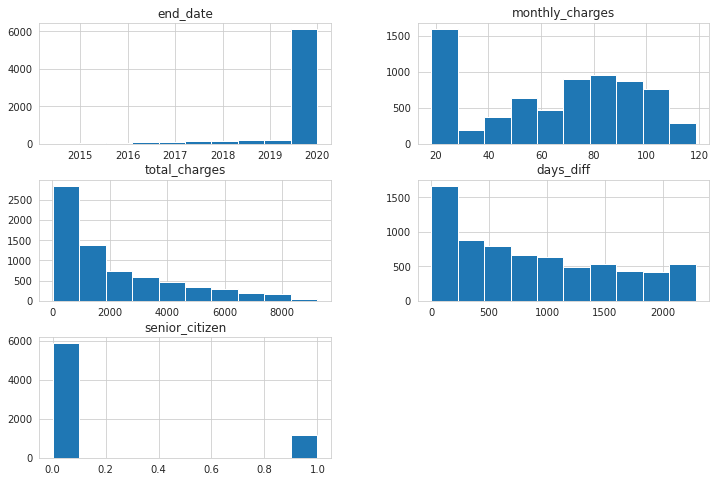

In [40]:
_ = merged_df.hist()

In [41]:
merged_df.describe()

,monthly_charges,total_charges,days_diff,senior_citizen
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,64.798208,2118.621822,874.658419,0.162400
std,30.085974,2112.736199,682.997127,0.368844
min,18.250000,19.050000,1.000000,0.000000
25%,35.587500,439.745000,246.000000,0.000000
50%,70.350000,1345.275000,731.000000,0.000000
75%,89.862500,3239.317500,1431.000000,0.000000
max,118.750000,9221.380000,2284.000000,1.000000


Видно, что:
* В основном клиенты пользуются услугами недавно (до 250 дней)
* Свыше 6_000 клиентов ( > 85%) не перестали пользоваться услугами на период сборки датасета
* Большинство клиентов - не пенсионеры
* Большинство клиентов - не ушло, а количество ушедших больше всего было в 2018 году
  
На примере с пенсионерами и выплатами виден чёткий дисбаланс классов; он нам не помешает, т.к. качество финальной модели мы будем оценивать метрикой `AUC-ROC`, а она не чувствительна к дисбалансу.

**Обработаем пропуски:**

In [42]:
merged_df

,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,days_diff,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,2020-01-02,Two year,No,Electronic check,59.00,3717.00,1888,Male,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,NaN
1,2020-01-02,Two year,No,Mailed check,67.85,5000.55,2011,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,No,Yes,No
2,2020-01-02,Month-to-month,Yes,Mailed check,50.30,102.61,32,Male,0,No,No,DSL,No,Yes,No,No,No,No,No
3,2018-09-01,Month-to-month,Yes,Electronic check,85.10,595.70,212,Male,0,Yes,No,Fiber optic,No,No,No,No,No,Yes,Yes
4,2020-01-02,One year,No,Mailed check,55.15,724.12,366,Female,0,No,No,DSL,Yes,No,No,Yes,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,2020-01-02,Month-to-month,Yes,Mailed check,83.90,444.67,123,Female,1,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,No
7028,2020-01-02,Month-to-month,Yes,Electronic check,98.00,1372.00,397,Male,1,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,No
7029,2020-01-02,Month-to-month,Yes,Electronic check,73.90,406.45,123,Male,0,No,No,Fiber optic,No,No,Yes,No,No,No,No
7030,2020-01-02,Month-to-month,No,Mailed check,59.90,539.10,246,Male,0,No,No,DSL,No,No,No,No,No,Yes,Yes


In [45]:
for col in merged_df.columns: # процент пропусков
        pct_missing = np.mean(merged_df[col].isnull())
        print('{} - {}%'.format(col, round(pct_missing*100, 3)))

end_date - 0.0%
type - 0.0%
paperless_billing - 0.0%
payment_method - 0.0%
monthly_charges - 0.0%
total_charges - 0.0%
days_diff - 0.0%
gender - 0.0%
senior_citizen - 0.0%
partner - 0.0%
dependents - 0.0%
internet_service - 21.615%
online_security - 21.615%
online_backup - 21.615%
device_protection - 21.615%
tech_support - 21.615%
streaming_tv - 21.615%
streaming_movies - 21.615%
multiple_lines - 9.67%


Непонятно, как заполнять пропуски, поэтому, где данные похожи на бинарные (содержат только значения `Yes`, `No`), пропуски будем заполнять значением `No`, отталкиваясь от предположения, что пользователь не стал заполнять эту информацию, т.к. не мог дать положительный ответ (отсутствие услуги). В столбце же `internet_service` пропуски заполним значением `unkwn` (от англ. `Unknown`, неизвестный)

In [46]:
merged_df['internet_service'] = merged_df['internet_service'].fillna('unkwn')

In [47]:
merged_df['internet_service'].unique()

array(['DSL', 'Fiber optic', 'unkwn'], dtype=object)

In [48]:
merged_df['internet_service'].isna().sum()

0

In [49]:
columns = merged_df.columns[-7:]
columns

Index(['online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines'],
      dtype='object')

In [50]:
for col in columns:
    merged_df[col] = merged_df[col].fillna('No')
    print(color.BOLD + col + color.END)
    print('\tunique:', merged_df[col].unique())
    print('\tNaN:', merged_df[col].isna().sum(), end='\n\n')

online_security
	unique: ['Yes' 'No']
	NaN: 0

online_backup
	unique: ['Yes' 'No']
	NaN: 0

device_protection
	unique: ['Yes' 'No']
	NaN: 0

tech_support
	unique: ['No' 'Yes']
	NaN: 0

streaming_tv
	unique: ['Yes' 'No']
	NaN: 0

streaming_movies
	unique: ['Yes' 'No']
	NaN: 0

multiple_lines
	unique: ['No' 'Yes']
	NaN: 0



**=>** Все пропуски заполнены корректно

Выделим целевой признак и разделим все данные на тренировочные и тестовы в соотношении 3:1
Целевым признаком является столбец `end_date`; закодируем его вручную

In [51]:
merged_df['is_client'] = (merged_df['end_date'] == '01-02-2020').astype(int)
merged_df = merged_df.drop('end_date', axis=1)

In [52]:
merged_df.sample(10, random_state=RANDOM_SEED)

,type,paperless_billing,payment_method,monthly_charges,total_charges,days_diff,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,is_client
6709,Two year,No,Credit card (automatic),24.25,1868.22,2161,Female,0,Yes,Yes,unkwn,No,No,No,No,No,No,Yes,1
6340,Two year,Yes,Bank transfer (automatic),74.35,4492.23,1707,Male,0,No,No,DSL,Yes,No,Yes,No,Yes,Yes,No,1
6473,Month-to-month,No,Electronic check,83.85,2263.95,792,Female,1,Yes,No,DSL,No,Yes,Yes,Yes,Yes,Yes,Yes,1
2235,Two year,No,Credit card (automatic),19.40,314.28,456,Female,0,Yes,Yes,unkwn,No,No,No,No,No,No,No,0
2871,Month-to-month,Yes,Electronic check,50.15,309.93,154,Male,0,Yes,Yes,DSL,No,No,Yes,No,No,No,No,1
3592,Month-to-month,Yes,Electronic check,87.10,766.48,215,Female,1,No,No,Fiber optic,No,Yes,No,No,Yes,No,No,1
2323,One year,No,Credit card (automatic),110.45,3313.50,884,Female,0,No,No,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Yes,1
6671,Two year,Yes,Electronic check,114.60,8182.44,2102,Male,0,No,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,1
4453,Month-to-month,Yes,Credit card (automatic),19.65,98.25,123,Female,0,No,No,unkwn,No,No,No,No,No,No,No,1
3046,Month-to-month,Yes,Bank transfer (automatic),64.50,193.50,62,Female,0,No,Yes,DSL,Yes,No,No,Yes,No,Yes,No,1


Разделим столбцы на строковые и числовые:

In [53]:
enc_columns = []
num_columns = []
for col in merged_df.columns:
    if merged_df[col].dtype == 'O':
        enc_columns.append(col)
    else:
        num_columns.append(col)

In [54]:
num_columns

['monthly_charges',
 'total_charges',
 'days_diff',
 'senior_citizen',
 'is_client']

In [55]:
enc_columns

['type',
 'paperless_billing',
 'payment_method',
 'gender',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines']

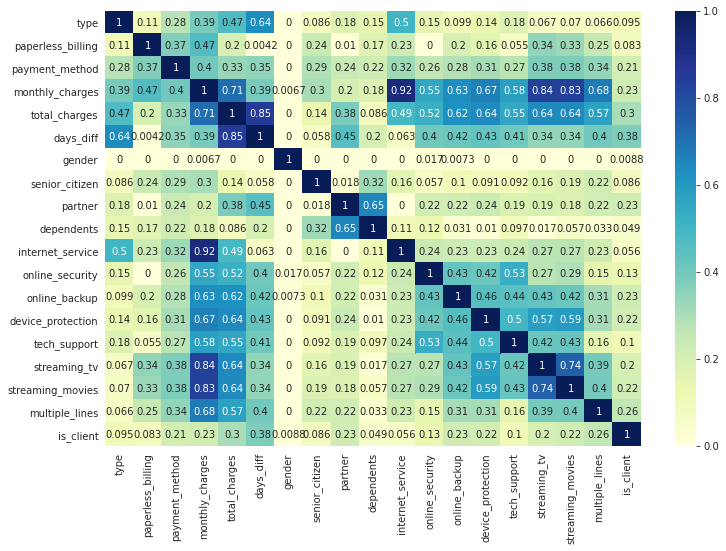

In [56]:
phik_corr_matrix = phik_matrix(merged_df, interval_cols=num_columns)

sns.heatmap(phik_corr_matrix, annot=True, cmap="YlGnBu")
_ = plt.show()

Из матрицы корреляций Фай-Фулкерсона видно, что данные о гендере (столбец `gender`) почти никак не коррелируют со всеми остальными: его можно сбросить. Такие же размышления применимы и к столбцам `senior_citizen`, `dependents`.

## Подготовка данных

In [58]:
# Добавление нового столбца на основе существующего
merged_df['is_senior'] = merged_df['senior_citizen'].apply(lambda x: 'Yes' if x == 1 else 'No')

# Вывод DataFrame с новым столбцом
merged_df[['is_senior', 'senior_citizen']]


,is_senior,senior_citizen
0,No,0
1,No,0
2,No,0
3,No,0
4,No,0
...,...,...
7027,Yes,1
7028,Yes,1
7029,No,0
7030,No,0


In [59]:
merged_df = merged_df.drop(columns='senior_citizen', axis=1)

**Масштабируем** числовые данные:

Выкинем столбец с целевым признаком:

In [60]:
enc_columns = []
num_columns = []
for col in merged_df.columns:
    if merged_df[col].dtype == 'O':
        enc_columns.append(col)
    else:
        num_columns.append(col)

In [61]:
num_columns.remove('is_client')

In [62]:
num_columns

['monthly_charges', 'total_charges', 'days_diff']

In [63]:
enc_columns

['type',
 'paperless_billing',
 'payment_method',
 'gender',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines',
 'is_senior']

Выделим целевой признак, а также тренировочную и тестовую выборки:

In [64]:
target = merged_df['is_client']
features = merged_df.drop('is_client', axis=1)

In [65]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25,
                                                                            random_state=RANDOM_SEED)

In [66]:
#кодирование данных

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM_SEED)

# Identifying numeric and categorical features
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# Creating transformers for the preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Scaling numeric features
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first'))  # One-hot encoding categorical features, dropping the first column
])

# Combining transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Applying the transformations to the training and test sets
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Extracting new column names for the transformed features
new_numeric_features = numeric_features.tolist()
# new_categorical_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
new_categorical_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out()

# Combining all new feature names
all_new_features = new_numeric_features + new_categorical_features.tolist()

# Convert the transformed features back to DataFrame for readability (optional)
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=all_new_features, index=X_train.index)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=all_new_features, index=X_test.index)

**=>** Данные разделены и предобработаны корректно

In [67]:
scaler = StandardScaler()

In [68]:
features_train[num_columns] = scaler.fit_transform(features_train[num_columns])
features_test[num_columns] = scaler.fit_transform(features_test[num_columns])

In [69]:
try:
    encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

    encoder_df = pd.DataFrame(encoder.fit_transform(features_train[enc_columns]).toarray())
    enc_features_train = features_train.join(encoder_df)

    encoder_df = pd.DataFrame(encoder.fit_transform(features_test[enc_columns]).toarray())
    encfeatures_test = features_test.join(encoder_df)
except:
    print('\nError occured.')
    encoder = OneHotEncoder(handle_unknown='ignore')
    
    encoder_df = pd.DataFrame(encoder.fit_transform(features_train[enc_columns]).toarray())
    enc_features_train = (features_train.reset_index()).join(encoder_df)

    encoder_df = pd.DataFrame(encoder.fit_transform(features_test[enc_columns]).toarray())
    enc_features_test = (features_test.reset_index()).join(encoder_df)


Error occured.


In [70]:
enc_features_train = enc_features_train.drop(columns=enc_columns, axis=1)
enc_features_test = enc_features_test.drop(columns=enc_columns, axis=1)

In [71]:
enc_features_train = enc_features_train.drop(columns='index')
enc_features_train.sample(5, random_state=RANDOM_SEED)

,monthly_charges,total_charges,days_diff,0,1,2,3,4,5,6,...,24,25,26,27,28,29,30,31,32,33
4009,-1.486934,-0.789014,-0.334809,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1397,0.389213,-0.017092,-0.113327,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
77,0.709694,-0.872828,-1.184065,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3845,1.318941,2.825212,1.894674,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3020,-0.649010,-0.368775,-0.023855,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [72]:
enc_features_test = enc_features_test.drop(columns='index')
enc_features_test.sample(5, random_state=RANDOM_SEED)

,monthly_charges,total_charges,days_diff,0,1,2,3,4,5,6,...,24,25,26,27,28,29,30,31,32,33
1127,0.290078,-0.949266,-1.251576,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
374,1.587631,-0.426037,-0.810020,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
1097,0.298290,0.052220,0.029374,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1039,-0.209234,0.851935,1.718362,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
1624,-0.439180,-0.418419,-0.278113,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


Данные успешно закодированы

## Обучение моделей машинного обучения

Обучим следующие модели:
* LogisticRegression
* CatBoost

**LogisticRegression**

In [73]:
temp = list(enc_features_train.columns[0:3])
for i in list(enc_features_train.columns[3:]):
    temp.append(str(i))

enc_features_train.columns = temp
enc_features_train.columns

Index(['monthly_charges', 'total_charges', 'days_diff', '0', '1', '2', '3',
       '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16',
       '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28',
       '29', '30', '31', '32', '33'],
      dtype='object')

In [74]:
%%time

model = LogisticRegression(random_state=RANDOM_SEED)
model.fit(enc_features_train, target_train)

# Предсказание вероятностей классов для тестовой выборки
predictions = model.predict_proba(enc_features_train)[:, 1]

# Вычисление AUC-ROC
lr_auc_roc = roc_auc_score(target_train, predictions)

print(f"AUC-ROC: {lr_auc_roc:.4f}")

AUC-ROC: 0.7781
CPU times: user 152 ms, sys: 163 ms, total: 315 ms
Wall time: 261 ms


**CatBoost**

In [75]:
%%time

param_dist = {
     'iterations': [100, 500, 1000],
    'learning_rate': uniform(0.01, 0.3),
    'depth': [4, 6, 8, 10]}


# Inisialization model CatBoostClassifier
catboost_model = CatBoostClassifier(verbose=False, eval_metric='AUC', loss_function='Logloss', random_seed=RANDOM_SEED)

#  RandomizedSearchCV
random_search = RandomizedSearchCV(catboost_model, param_distributions=param_dist, n_iter=10,
                                   scoring='roc_auc', cv=3, random_state=RANDOM_SEED, verbose=2)

# fit model with RandomizedSearchCV
random_search.fit(X_train_transformed_df, y_train)

#проверка на тестовых данных

print(f"\nbest params: {random_search.best_params_}")
print(f"best ROC AUC: {random_search.best_score_:.4f}")

best_model = random_search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END depth=10, iterations=100, learning_rate=0.22317596425688302; total time=   2.5s
[CV] END depth=10, iterations=100, learning_rate=0.22317596425688302; total time=   2.4s
[CV] END depth=10, iterations=100, learning_rate=0.22317596425688302; total time=   2.5s
[CV] END depth=4, iterations=1000, learning_rate=0.11187815841373282; total time=   1.8s
[CV] END depth=4, iterations=1000, learning_rate=0.11187815841373282; total time=   2.0s
[CV] END depth=4, iterations=1000, learning_rate=0.11187815841373282; total time=   1.8s
[CV] END depth=8, iterations=100, learning_rate=0.2521235502410333; total time=   1.2s
[CV] END depth=8, iterations=100, learning_rate=0.2521235502410333; total time=   1.4s
[CV] END depth=8, iterations=100, learning_rate=0.2521235502410333; total time=   1.2s
[CV] END depth=8, iterations=100, learning_rate=0.04645380528996295; total time=   1.2s
[CV] END depth=8, iterations=100, learning_rate=0.046453

## Выбор лучшей модели

Лучше всего отработала модель **CatBoostClassifier**, достигнув метрики `AUC-ROC` равной 0.93; на этой модели и будем проверять наши тестовые данные

In [77]:
%%time

#testing on test set
y_pred = best_model.predict(X_test_transformed_df)
y_pred_proba = best_model.predict_proba(X_test_transformed_df)[:, 1]

#  ROC AUC and Accuracy
roc_auc_test = roc_auc_score(y_test, y_pred_proba)
accuracy_test = accuracy_score(y_test, y_pred)

print(f"test AUC-ROC: {roc_auc_test:.4f}")
print(f"accuracy test: {accuracy_test:.4f}")

test AUC-ROC: 0.9501
accuracy test: 0.9408
CPU times: user 16.7 ms, sys: 0 ns, total: 16.7 ms
Wall time: 16 ms


## Вывод для заказчика

В ходе этого проекта мы выполнили все поставленные задачи, а именно:

* Собрали портрет всех клиентов в одной таблице, изучили и предобработали её, сделали выводы по каждому этапу
* Подготовили данные к обучению моделей машинного обучения
* Для качественного прогноза оттока клиентов обучили следующие модели:
    * LogisticRegression
    * CatBoostClassifier

По результатам работы мы построили модель машинного обучения на основе `CatBoost`, которая очень точно предсказывает отток клиентов: метрика `AUC-ROC` на этой модели равна 0.95, что является очень хорошим показателем. Данную метрику было удобнее использовать для данной задачи, так как в собранных данных наблюдался сильный дисбаланс нескольких классов. Также при проверке этой модели на тестовых данных мы получили `accuracy_test` = 0.94, что говорит о том, что модель хорошо справляется с предсказаниями.  
  
Для эффективного удержания клиентов, рекомендуется использовать разработанную модель для предсказания потенциального оттока.